In [1]:
from tensorflow.keras.models import load_model
import tflite_runtime.interpreter as tflite
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


# Load model
interpreter = tflite.Interpreter(model_path='models/demo_0507.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

2024-05-19 23:29:11.448337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 23:29:13.737509: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 23:29:13.766854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 23:29:17.936772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = datagen.flow_from_directory(
    'dataset/test',  # Path to your testing dataset organized by classes
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # Important to maintain the order of samples
)

Found 240 images belonging to 4 classes.


In [3]:
# Function to make predictions using the TFLite model
def predict_tflite(interpreter, test_generator):
    predicted_labels = []
    for i in range(len(test_generator)):
        image, label = test_generator[i]
        image = image.astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_labels.append(np.argmax(output))
    return np.array(predicted_labels)

In [4]:
predicted_labels = predict_tflite(interpreter, test_generator)
true_labels = test_generator.classes

## CONFUSION MATRIX

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Normalized Confusion Matrix


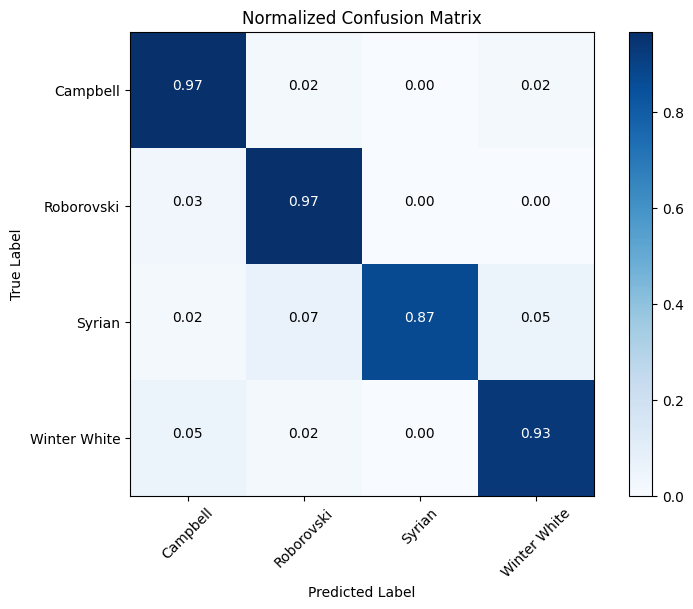

In [6]:
confusion = confusion_matrix(true_labels, predicted_labels)
class_names = ['Campbell', 'Roborovski', 'Syrian', 'Winter White']
plot_confusion_matrix(confusion, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score

# Calculate the overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall Accuracy: {accuracy:.2f}')

Overall Accuracy: 0.93


## CLASSIFICATION REPORT

In [9]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    Campbell       0.91      0.97      0.94        60
  Roborovski       0.91      0.97      0.94        60
      Syrian       1.00      0.87      0.93        60
Winter White       0.93      0.93      0.93        60

    accuracy                           0.93       240
   macro avg       0.94      0.93      0.93       240
weighted avg       0.94      0.93      0.93       240

